# ALL REGRESSIONS

In this version, all plotting will take place separately. We will save data to a csv and then plot from there. In doing so, we will be able save results.

Still need to implement the idea of train/test for linear regression: seeing how well our model works

In [73]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make_reg # default is 100 samples, 100 features
from sklearn.datasets import make_classification as Make_class # default is 100 samples, 20 features, 2 classes
from sklearn.model_selection import train_test_split as split
def ren(x): return range(len(x))

class Regression:
    def __init__(self, error, time_limit):
        self.time_limit = time_limit
        self.error = error # epsilon/tolerence
            
    def makeLinearRegressionDataset(self): # make a dataset using sklearn's Make Regression
        dataset = Make_reg(800,1000)
        self.a_copy = dataset[0]
        self.b_copy = dataset[1]
        self.x_copy = np.random.rand(len(self.a_copy[0]))
    
    def importLinearRegressionDataset(self, dataset): # import a regression dataset from sklearn
        dataset = dataset(return_X_y=True)
        self.a_copy = dataset[0]
        self.b_copy = dataset[1]
        self.x_copy = np.random.rand(len(self.a_copy[0]))
        
    def customLinearRegressionDataset(self, a, b):
        self.a_copy = a
        self.b_copy = b
        self.x_copy = np.random.rand(len(self.a_copy[0]))
        
    def f_Lin(self, X): # linear Regression Function
        return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
    def g_Lin(self, X): # linearRegressionFunctionGradient
        return self.a.T @ (self.a @ X - self.b)
    def GD_Lin(self): # Linear Regression gradient descent
        self.x = self.x - self.lam*self.grad
    
    def Vanilla_Linear_Reg(self, directory): # using a fixed step size of 1/L
        # set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.lam = 1/np.max( np.linalg.svd( self.a @ self.a.T ) [1] ) # find step size
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            self.GD_Lin()
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList})
#         self.LinearVanDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearVanDF.to_csv(directory, index = False)
    
    def Adaptive_Linear_Reg(self, directory): # in which the step size adapts to local curvature
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.lam = random.random()+1e-12 # initialise step size > 0
        self.theta = np.inf # initialise theta = infty
        x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime] # to show time taken
        
        self.GD_Lin()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Lin(self.x)
        self.gradNorm = np.linalg.norm(self.grad)
        self.gradientValuesList.append(self.gradNorm)
#         self.functionVals.append(self.f_Lin(self.x))
        self.timeList.append(time.time() - self.initialTime)
        # loop
        while self.gradNorm > self.error:
            lam0 = deepcopy(self.lam) # copy initial step size
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.x - x0) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - self.oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Lin() # steepest descent
            self.theta = self.lam / lam0 # calc theta
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList})
#         self.LinearAdapDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearAdapDF.to_csv(directory, index = False)
    
    def Grad_LineSearch_Linear_Reg(self, directory): # using a line search
        def BackTrack():
            rho = random.random()
            lam = random.randrange(10)
            while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):
                lam = rho * lam
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        return None
            self.lam = lam
            
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            BackTrack()
            self.GD_Lin()
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearLineSearchDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList})
#         self.LinearLineSearchDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearLineSearchDF.to_csv(directory, index = False)
            
    def Barzilai_Linear_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        self.lam = random.random()+1e-12 # initialise step size > 0
        x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime] # to show time taken
        self.GD_Lin()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
#         self.functionVals.append(self.f_Lin(self.x))
        self.timeList.append(time.time() - self.initialTime)
        # loop
        while self.gradNorm > self.error:
            nom = np.dot(self.x - x0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / denom            
            x0 = deepcopy(self.x) # make a coopy of x to preserve previous x
            self.GD_Lin() # steepest descent
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
#         self.LinearBarzDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList})
        self.LinearBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Linear_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.x = deepcopy(self.x_copy) # make copies to use
        self.a = deepcopy(self.a_copy)
        self.b = deepcopy(self.b_copy)
        L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        self.grad = self.g_Lin(self.x) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
#         self.functionVals = [self.f_Lin(self.x)] # to show function value convergence
        self.timeList = [time.time() - self.initialTime]
        lam1 = 1
        y0 = deepcopy(self.x)
        while self.gradNorm > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            self.gamma = (1 - lam1)/self.lam
            y1 = self.x - self.grad/L
            self.x = (1 - self.gamma)*y1 + self.gamma*y0
            lam1 = deepcopy(self.lam)
            y0 = deepcopy(y1)
            self.grad = self.g_Lin(self.x)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
#             self.functionVals.append(self.f_Lin(self.x))
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LinearNestDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList})
#         self.LinearNestDF = pd.DataFrame(
#             {'GradientNorms': self.gradientValuesList , 
#              'TimeTaken': self.timeList, 'FunctionValues': self.functionVals})
        self.LinearNestDF.to_csv(directory, index = False)
    
    #-------------------------------------------------------------------------------------------
    
    def makeLogisticRegressionDataset(self):
        sample_data = Make_class()
        ones = np.array([[1]*len(sample_data[0])])
        augmented_data = np.concatenate((ones.T, self.normalise(sample_data[0])), axis =1) # add a 1 to the start of each feature
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( augmented_data, sample_data[1], \
                                                                 test_size = 0.1)
        self.weights_copy = np.random.rand( len(self.xTrain[0]) )
        
    def importLogisticRegressionDataset(self, dataset, multi = False):
        if multi == True:
            sample_data = dataset(return_X_y=True, n_class = 2)
        else:
            sample_data = dataset(return_X_y=True)
        ones = np.array([[1]*len(sample_data[0])])
        augmented_data = np.concatenate((ones.T, self.normalise(sample_data[0])), axis =1) # add a 1 to the start of each feature
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( augmented_data, sample_data[1], \
                                                                 test_size = 0.1)
        self.weights_copy = np.random.rand( len(self.xTrain[0]) )
    
    def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function
    
    def normalise(self, X): # normalises the input data to values between 0 and 1
        mins = np.min(X, axis = 0) 
        maxs = np.max(X, axis = 0) 
        rng = maxs - mins 
        norm_X = 1 - ((maxs - X)/rng) 
        return norm_X
    
    def f_Log(self, W): # function f: the inverse of the log likelihood function, modelling the probability of the data xTrain and xTest
        sig = self.sigmoid(W, self.xTrain)
        step1 = self.yTrain * np.log(sig + 1e-300) # returns an array with log(sig) values where yTrain =1, else 0
        step2 = (1 - self.yTrain) * np.log(1 - sig + 1e-300 )
        final = -step1 - step2 
        return np.mean(final)
    
    def g_Log(self, W): # the gradient function of f, simply (h(w) - y) * x
        sig = self.sigmoid(W, self.xTrain)
        inner_expr = sig - self.yTrain
        return inner_expr.T @ self.xTrain
    
    def GD_Log(self): # Step size calculator - w_1 = w_0 - lam* gradient(w)
        self.weights = self.weights - self.lam * self.g_Log(self.weights)
        
    def classify(self):
        sig = self.sigmoid(self.weights, self.xTest)
        predict = np.squeeze( np.where( sig >= 0.5, 1, 0 ) )
        self.preds = sum( predict == self.yTest ) / len(self.xTest)
    
    def Vanilla_Logistic_Reg(self, directory):
        self.initialTime= time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make a copy of the weights
        self.lam = 1/np.max(np.linalg.svd( self.xTrain @ self.xTrain.T )[1]) # find step size
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.GD_Log()
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticVanDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticVanDF.to_csv(directory, index = False)
    
    def Adaptive_Logistic_Reg(self, directory):
        self.initialTime= time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make a copy of the weights
        self.lam = random.random()+1e-12 # initialise step size > 0
        self.theta = np.inf # initialise theta = infty
        weights0 = deepcopy(self.weights) # make a coopy of weights to preserve previous weights
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        
        self.GD_Log()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
        self.functionVals.append(self.f_Log(self.weights))
        self.classify()
        self.predList.append(self.preds)
        self.timeList.append(time.time() - self.initialTime)
        while self.gradNorm > self.error:
            lam0 = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam # 1st part of step size calc
            min2_nom = np.linalg.norm(self.weights - weights0) # 2nd part of step size calc
            min2_denom = 2*np.linalg.norm(self.grad - self.oldGrad) # as above
            self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
            weights0 = deepcopy(self.weights) # make a coopy of x to preserve previous x
            self.GD_Log() # steepest descent
            self.theta = self.lam / lam0 # calc theta
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticAdapDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticAdapDF.to_csv(directory, index = False)
        
    def Grad_LineSearch_Logistic_Reg(self, directory): # using a line search
        def BackTrack():
            rho = random.random()
            lam = random.randrange(10) # try using a less stupid number
            while 1>(self.gradNorm/np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad)):
                lam = rho * lam
                if self.time_limit > 0:
                    if (time.time() - self.initialTime) > self.time_limit:
                        return None
            self.lam = lam
        #set up
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_copy)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime]
        # loop
        while self.gradNorm > self.error:
            BackTrack()
            self.GD_Log()
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
#             k+=1
        self.LogisticLineDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticLineDF.to_csv(directory, index = False)
    
    def Barzilai_Logistic_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_copy) # make copies to use
        self.lam = random.random()+1e-12 # initialise step size > 0
        weights0 = deepcopy(self.weights) # make a copy of weughts to preserve previous weights
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        self.timeList = [time.time() - self.initialTime] # to show time taken
        
        self.GD_Log()
        self.oldGrad = deepcopy(self.grad)
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList.append(self.gradNorm)
        self.functionVals.append(self.f_Log(self.weights))
        self.classify()
        self.predList.append(self.preds)
        self.timeList.append(time.time() - self.initialTime)
        # loop
        k = 0
        while (self.gradNorm > self.error and k <10):
            nom = np.dot(self.weights - weights0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / (denom +1e-300)           
            weight_backup = deepcopy(self.weights)
            self.GD_Log() # steepest descent
            # we don't update oldGrad in this loop
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
            k=k+1
        weights0 = weight_backup
        self.oldGrad = self.g_Log(weights0)
        while self.gradNorm > self.error:
            nom = np.dot(self.weights - weights0, self.grad - self.oldGrad )
            denom = np.linalg.norm(self.grad - self.oldGrad)**2
            self.lam = nom / (denom +1e-300)          
            weights0 = deepcopy(self.weights) # make a coopy of x to preserve previous x
            self.GD_Log() # steepest descent
            self.oldGrad = deepcopy(self.grad)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticBarzDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticBarzDF.to_csv(directory, index = False)
        
    def Nesterov_Logistic_Reg(self, directory):
        #set up
        self.initialTime = time.time() # start the clock
        L = np.max(np.linalg.svd( self.xTrain @ self.xTrain.T )[1]) # find L
        self.weights = deepcopy(self.weights_copy) # make copies to use
        self.grad = self.g_Log(self.weights) # calculate gradient
        self.gradNorm = np.linalg.norm(self.grad) # calc the l2 norm of the gradient
        self.gradientValuesList = [self.gradNorm] # initialise ...
        self.functionVals = [self.f_Log(self.weights)] # to show function value convergence
        self.classify()
        self.predList = [self.preds]
        lam1 = 1
        y0 = deepcopy(self.weights)
        self.timeList = [time.time() - self.initialTime]
        while self.gradNorm > self.error:
            self.lam = 0.5*(1 + np.sqrt(1 + 4*lam1**2))
            self.gamma = (1 - lam1)/self.lam 
            y1 = self.weights - self.grad/L
            self.weights = (1 - self.gamma)*y1 + self.gamma*y0
            lam1 = deepcopy(self.lam)
            y0 = deepcopy(y1)
            self.grad = self.g_Log(self.weights)
            self.gradNorm = np.linalg.norm(self.grad)
            self.gradientValuesList.append(self.gradNorm)
            self.functionVals.append(self.f_Log(self.weights))
            self.classify()
            self.predList.append(self.preds)
            self.timeList.append(time.time() - self.initialTime)
            if self.time_limit > 0:
                if (time.time() - self.initialTime) > self.time_limit:
                    break
        self.LogisticNestDF = pd.DataFrame(
            {'GradientNorms': self.gradientValuesList , 
             'TimeTaken': self.timeList, 'FunctionValues': self.functionVals, 'Accuracy': self.predList})
        self.LogisticNestDF.to_csv(directory, index = False)

def RunAll(error, runtime, date_time):
    global H
    H = Regression(error, runtime)
    run_lin(date_time)
    print('Linear Regression complete')
    run_log(date_time)
    print('Logistic Regression complete')
    read_lin(date_time)
    read_log(date_time)

def run_lin(date_time):
    H.makeLinearRegressionDataset()
    H.Adaptive_Linear_Reg("output/Lin_Test_Adap_{}.csv".format(date_time))
    H.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Linear_Reg("output/Lin_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Linear_Reg("output/Lin_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Linear_Reg("output/Lin_Test_Nest_{}.csv".format(date_time))
def read_lin(date_time):
    global Lin_vanilla_out
    Lin_vanilla_out = pd.read_csv("output/Lin_Test_Van_{}.csv".format(date_time))
    global Lin_adap_out
    Lin_adap_out = pd.read_csv("output/Lin_Test_Adap_{}.csv".format(date_time))
    global Lin_line_out
    Lin_line_out = pd.read_csv("output/Lin_Test_LS_{}.csv".format(date_time))
    global Lin_baz_out
    Lin_baz_out = pd.read_csv("output/Lin_Test_Baz_{}.csv".format(date_time))
    global Lin_nest_out
    Lin_nest_out = pd.read_csv("output/Lin_Test_Nest_{}.csv".format(date_time))

def run_log(date_time):
    H.makeLogisticRegressionDataset()
    H.Adaptive_Logistic_Reg("output/Log_Test_Adap_{}.csv".format(date_time))
    H.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_{}.csv".format(date_time))
    H.Vanilla_Logistic_Reg("output/Log_Test_Van_{}.csv".format(date_time))
    H.Barzilai_Logistic_Reg("output/Log_Test_Baz_{}.csv".format(date_time))
    H.Nesterov_Logistic_Reg("output/Log_Test_Nest_{}.csv".format(date_time))
def read_log(date_time):
    global Log_vanilla_out
    Log_vanilla_out = pd.read_csv("output/Log_Test_Van_{}.csv".format(date_time))
    global Log_adap_out
    Log_adap_out = pd.read_csv("output/Log_Test_Adap_{}.csv".format(date_time))
    global Log_line_out
    Log_line_out = pd.read_csv("output/Log_Test_LS_{}.csv".format(date_time))
    global Log_baz_out
    Log_baz_out = pd.read_csv("output/Log_Test_Baz_{}.csv".format(date_time))
    global Log_nest_out
    Log_nest_out = pd.read_csv("output/Log_Test_Nest_{}.csv".format(date_time))

In [2]:
RunAll(1e-6,10,"14.09.21_12.14")

<ipython-input-1-666ce6431c6d>:119: RuntimeWarning: divide by zero encountered in double_scalars
  while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):


Linear Regression complete


<ipython-input-1-666ce6431c6d>:334: RuntimeWarning: divide by zero encountered in double_scalars
  self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
<ipython-input-1-666ce6431c6d>:358: RuntimeWarning: divide by zero encountered in double_scalars
  while 1>(self.gradNorm/np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad)):


Logistic Regression complete


In [74]:
H = Regression(1e-6, 20)
run_lin("14.09_16.58")
read_lin("14.09_16.58")

<ipython-input-73-f8cbf140b6bc>:125: RuntimeWarning: divide by zero encountered in double_scalars
  while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):


# Linear Regression Output

Full plot

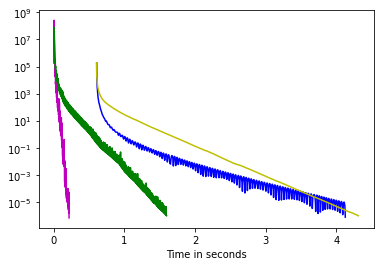

In [76]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
# plt.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

In [22]:
run_log("14.09_12.54")
read_log("14.09_12.54")

<ipython-input-17-593b4abb8dd4>:373: RuntimeWarning: divide by zero encountered in double_scalars
  while 1>(self.gradNorm/np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad)):


In [6]:
Lin_adap_out.TimeTaken.iloc[-1]

26.989213705062863

In [7]:
print("Van final", Lin_vanilla_out.tail())
print("Adap final", Lin_adap_out.tail())
print("LS final", Lin_line_out.tail())
print("Baz final", Lin_baz_out.tail())
print("Nest final", Lin_nest_out.tail())

Van final         GradientNorms  TimeTaken  FunctionValues
119319       0.016337  29.999000        0.133781
119320       0.016337  29.999496        0.133781
119321       0.016337  29.999496        0.133780
119322       0.016336  29.999993        0.133779
119323       0.016336  30.000488        0.133779
Adap final        GradientNorms  TimeTaken  FunctionValues
98403       0.016184  29.999446        0.043710
98404       0.011314  29.999446        0.043710
98405       0.009661  29.999942        0.043710
98406       0.009342  29.999942        0.043709
98407       0.009339  30.000438        0.043709
LS final       GradientNorms  TimeTaken  FunctionValues
2289       0.105945  29.996943        0.382954
2290       0.105385  29.997935        0.382908
2291       0.105385  29.998571        0.382908
2292       0.096926  29.999918        0.382892
2293       0.095250  30.000416        0.382878
Baz final       GradientNorms  TimeTaken  FunctionValues
8147   1.001002e-06   2.340477    5.008189e-10
81

# Logistic Regression output

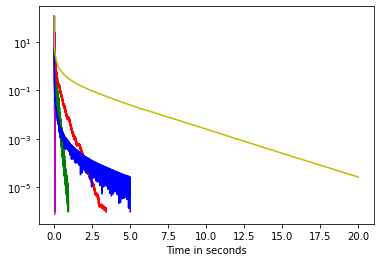

In [25]:
plt.plot(Log_baz_out.TimeTaken, Log_baz_out.GradientNorms, c = 'm')
plt.plot(Log_adap_out.TimeTaken, Log_adap_out.GradientNorms, c = 'g')
plt.plot(Log_line_out.TimeTaken, Log_line_out.GradientNorms, c = 'r')
plt.plot(Log_nest_out.TimeTaken, Log_nest_out.GradientNorms, c = 'b')
plt.plot(Log_vanilla_out.TimeTaken, Log_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

In [24]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final         GradientNorms  TimeTaken  FunctionValues  Accuracy
158306       0.000026  19.999986        0.266524       0.8
158307       0.000026  19.999986        0.266524       0.8
158308       0.000026  19.999986        0.266524       0.8
158309       0.000026  19.999986        0.266524       0.8
158310       0.000026  20.000483        0.266524       0.8
Adap final       GradientNorms  TimeTaken  FunctionValues  Accuracy
5374   1.491682e-06   0.942872        0.266524       0.8
5375   1.128125e-06   0.942872        0.266524       0.8
5376   1.019933e-06   0.942872        0.266524       0.8
5377   1.000463e-06   0.943367        0.266524       0.8
5378   9.994029e-07   0.943367        0.266524       0.8
LS final       GradientNorms  TimeTaken  FunctionValues  Accuracy
4133   1.328206e-06   3.422856        0.266524       0.8
4134   1.085875e-06   3.422856        0.266524       0.8
4135   1.011570e-06   3.422856        0.266524       0.8
4136   1.253390e-06   3.423389        0.266524

# Real data

We'll look at two datasets for each type (initally):

Linear Regression:
- Diabetes https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes
- Boston Housing: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

Logistic Regression:
- Digits https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
- Breast Cancer https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

## Diabetes

In [28]:
from sklearn.datasets import load_diabetes as diabetes

In [29]:
G = Regression(1e-6, 10)
G.importLinearRegressionDataset(diabetes)
G.Adaptive_Linear_Reg("output/Lin_Test_Adap_diabetes.csv")
G.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_diabetes.csv".format(diabetes))
G.Vanilla_Linear_Reg("output/Lin_Test_Van_diabetes.csv".format(diabetes))
G.Barzilai_Linear_Reg("output/Lin_Test_Baz_diabetes.csv".format(diabetes))
G.Nesterov_Linear_Reg("output/Lin_Test_Nest_diabetes.csv".format(diabetes))

<ipython-input-17-593b4abb8dd4>:125: RuntimeWarning: divide by zero encountered in double_scalars
  while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):


In [30]:
read_lin("diabetes")

In [31]:
print("Van final", Lin_vanilla_out.tail())
print("Adap final", Lin_adap_out.tail())
print("LS final", Lin_line_out.tail())
print("Baz final", Lin_baz_out.tail())
print("Nest final", Lin_nest_out.tail())

Van final       GradientNorms  TimeTaken
7526   1.008096e-06   0.321786
7527   1.005952e-06   0.321786
7528   1.003812e-06   0.321786
7529   1.001677e-06   0.321786
7530   9.995459e-07   0.321786
Adap final       GradientNorms  TimeTaken
2118   1.231715e-06   0.134444
2119   4.001547e-06   0.134444
2120   1.162788e-06   0.134444
2121   1.018953e-06   0.134444
2122   9.753764e-07   0.134444
LS final       GradientNorms  TimeTaken
2466   1.057117e-06   0.869482
2467   1.136181e-06   0.869482
2468   1.054377e-06   0.869482
2469   1.130837e-06   0.869979
2470   9.962436e-07   0.869979
Baz final      GradientNorms  TimeTaken
225   1.299870e-06   0.009464
226   1.209841e-06   0.009464
227   1.276141e-05   0.009464
228   1.080773e-06   0.009464
229   9.290591e-07   0.009464
Nest final       GradientNorms  TimeTaken
2938   7.672189e-05   0.255967
2939   5.748126e-05   0.255967
2940   3.817883e-05   0.255967
2941   1.885586e-05   0.255967
2942   4.464878e-07   0.255967


In [32]:
np.argmax(np.where(Lin_line_out.TimeTaken >0.5, 1, 0))

1573

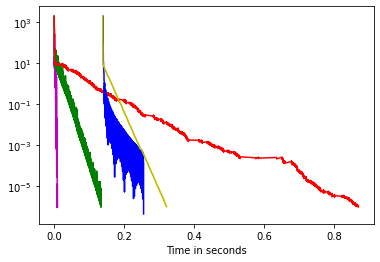

In [33]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
plt.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

## Boston Housing

In [34]:
from sklearn.datasets import load_boston as boston

In [35]:
I = Regression(1e-6, 60)
I.importLinearRegressionDataset(diabetes)
I.Adaptive_Linear_Reg("output/Lin_Test_Adap_boston.csv")
I.Grad_LineSearch_Linear_Reg("output/Lin_Test_LS_boston.csv")
I.Vanilla_Linear_Reg("output/Lin_Test_Van_boston.csv")
I.Barzilai_Linear_Reg("output/Lin_Test_Baz_boston.csv")
I.Nesterov_Linear_Reg("output/Lin_Test_Nest_boston.csv")

<ipython-input-17-593b4abb8dd4>:125: RuntimeWarning: divide by zero encountered in double_scalars
  while 1 > ( self.gradNorm/np.linalg.norm(self.g_Lin(self.x - lam*self.grad) - self.grad) ):


In [36]:
read_lin("boston")

In [37]:
print("Van final", Lin_vanilla_out.tail())
print("Adap final", Lin_adap_out.tail())
print("LS final", Lin_line_out.tail())
print("Baz final", Lin_baz_out.tail())
print("Nest final", Lin_nest_out.tail())

Van final       GradientNorms  TimeTaken
7526   1.008210e-06   0.331782
7527   1.006065e-06   0.331782
7528   1.003925e-06   0.332278
7529   1.001789e-06   0.332278
7530   9.996579e-07   0.332278
Adap final       GradientNorms  TimeTaken
2132   1.127266e-06   0.141825
2133   4.584687e-06   0.141825
2134   1.229147e-06   0.141825
2135   1.052943e-06   0.141825
2136   9.998823e-07   0.141825
LS final       GradientNorms  TimeTaken
2440   1.024747e-06   0.901243
2441   1.062882e-06   0.901243
2442   1.000669e-06   0.901715
2443   1.064199e-06   0.901715
2444   9.910164e-07   0.901715
Baz final      GradientNorms  TimeTaken
179   1.098629e-05    0.00847
180   7.776358e-06    0.00847
181   3.692223e-06    0.00847
182   1.999601e-06    0.00847
183   9.750660e-07    0.00847
Nest final       GradientNorms  TimeTaken
2938   7.673050e-05   0.273315
2939   5.748771e-05   0.273315
2940   3.818312e-05   0.273315
2941   1.885798e-05   0.273315
2942   4.465382e-07   0.273315


In [38]:
print("Van final", Lin_vanilla_out.head())
print("Adap final", Lin_adap_out.head())
print("LS final", Lin_line_out.head())
print("Baz final", Lin_baz_out.head())
print("Nest final", Lin_nest_out.head())

Van final    GradientNorms  TimeTaken
0    1948.367357   0.148261
1     547.948619   0.148261
2     403.046236   0.148261
3     300.211719   0.148261
4     226.134697   0.148261
Adap final    GradientNorms  TimeTaken
0    1948.367357    0.00049
1    1814.042642    0.00049
2     990.216678    0.00049
3     640.490680    0.00049
4     465.010598    0.00049
LS final    GradientNorms  TimeTaken
0    1948.367357   0.000484
1     544.531756   0.000484
2     204.690416   0.000980
3     105.866422   0.000980
4      64.587617   0.000980
Baz final    GradientNorms  TimeTaken
0    1948.367357   0.000503
1    3858.072115   0.001017
2     188.394156   0.001017
3     104.580016   0.001017
4      78.978905   0.001017
Nest final    GradientNorms  TimeTaken
0    1948.367357   0.145320
1     547.948619   0.145320
2     362.950764   0.145815
3     216.585056   0.145815
4     113.229953   0.145815


In [39]:
np.argmax(np.where(Lin_line_out.TimeTaken >0.5, 1, 0))

1278

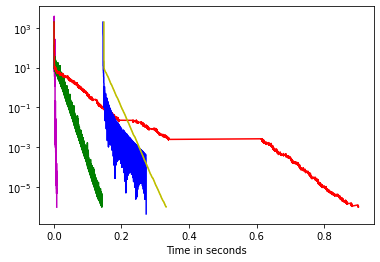

In [40]:
plt.plot(Lin_baz_out.TimeTaken, Lin_baz_out.GradientNorms, c = 'm')
plt.plot(Lin_adap_out.TimeTaken, Lin_adap_out.GradientNorms, c = 'g')
plt.plot(Lin_line_out.TimeTaken, Lin_line_out.GradientNorms, c = 'r')
plt.plot(Lin_nest_out.TimeTaken, Lin_nest_out.GradientNorms, c = 'b')
plt.plot(Lin_vanilla_out.TimeTaken, Lin_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

## Breast Cancer

In [41]:
from sklearn.datasets import load_breast_cancer as cancer

In [42]:
K = Regression(1e-6, 10)
K.importLogisticRegressionDataset(cancer)
K.Adaptive_Logistic_Reg("output/Log_Test_Adap_cancer.csv")
K.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_cancer.csv")
K.Vanilla_Logistic_Reg("output/Log_Test_Van_cancer.csv")
K.Barzilai_Logistic_Reg("output/Log_Test_Baz_cancer.csv")
K.Nesterov_Logistic_Reg("output/Log_Test_Nest_cancer.csv")

<ipython-input-17-593b4abb8dd4>:264: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, w, X): return 1.0/(1 + np.exp(-(X @ w))) # sigmoid function
<ipython-input-17-593b4abb8dd4>:349: RuntimeWarning: divide by zero encountered in double_scalars
  self.lam = np.min([min1, (min2_nom / min2_denom) ]) # calc new step size
<ipython-input-17-593b4abb8dd4>:373: RuntimeWarning: divide by zero encountered in double_scalars
  while 1>(self.gradNorm/np.linalg.norm(self.g_Log(self.weights - lam*self.grad) - self.grad)):


In [43]:
read_log("cancer")

In [44]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final        GradientNorms  TimeTaken  FunctionValues  Accuracy
14353       0.934579   9.997418        0.067331       1.0
14354       0.934535   9.998409        0.067330       1.0
14355       0.934491   9.998905        0.067329       1.0
14356       0.934447   9.999401        0.067328       1.0
14357       0.934403  10.000393        0.067327       1.0
Adap final        GradientNorms  TimeTaken  FunctionValues  Accuracy
13139       0.031376   9.997885        0.013104  0.894737
13140       0.031375   9.998876        0.013104  0.894737
13141       0.031376   9.999373        0.013103  0.894737
13142       0.031411   9.999868        0.013102  0.894737
13143       0.032946  10.000860        0.013101  0.894737
LS final       GradientNorms  TimeTaken  FunctionValues  Accuracy
2166       0.130185   9.811371        0.030566  0.929825
2167       0.137421   9.819308        0.030563  0.929825
2168       0.136780   9.826252        0.030561  0.929825
2169       0.135609   9.835676        0.030558

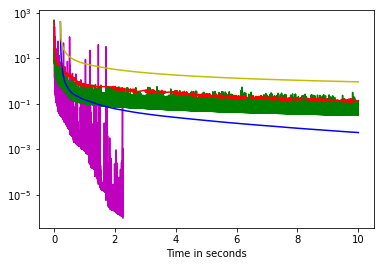

In [45]:
plt.plot(Log_baz_out.TimeTaken, Log_baz_out.GradientNorms, c = 'm')
plt.plot(Log_adap_out.TimeTaken, Log_adap_out.GradientNorms, c = 'g')
plt.plot(Log_line_out.TimeTaken, Log_line_out.GradientNorms, c = 'r')
plt.plot(Log_nest_out.TimeTaken, Log_nest_out.GradientNorms, c = 'b')
plt.plot(Log_vanilla_out.TimeTaken, Log_vanilla_out.GradientNorms, c = 'y')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

## Digits

In [38]:
from sklearn.datasets import load_digits as digits

In [39]:
dig = digits(n_class=2, return_X_y=True)

In [40]:
D = Regression(1e-6, 60)
D.importLogisticRegressionDataset(digits, multi=True)
D.Adaptive_Logistic_Reg("output/Log_Test_Adap_digits.csv")
D.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_digits.csv")
D.Vanilla_Logistic_Reg("output/Log_Test_Van_digits.csv")
D.Barzilai_Logistic_Reg("output/Log_Test_Baz_digits.csv")
D.Nesterov_Logistic_Reg("output/Log_Test_Nest_digits.csv")

<ipython-input-1-cf99a8526701>:250: RuntimeWarning: invalid value encountered in true_divide
  norm_X = 1 - ((maxs - X)/rng)


LinAlgError: SVD did not converge

In [27]:
D = Regression(1e-12, 60)
D.importLogisticRegressionDataset(digits, multi=True)

<ipython-input-1-cf99a8526701>:250: RuntimeWarning: invalid value encountered in true_divide
  norm_X = 1 - ((maxs - X)/rng)


In [33]:
H.normalise(dig[0][0])

array([0.        , 0.        , 0.33333333, 0.86666667, 0.6       ,
       0.06666667, 0.        , 0.        , 0.        , 0.        ,
       0.86666667, 1.        , 0.66666667, 1.        , 0.33333333,
       0.        , 0.        , 0.2       , 1.        , 0.13333333,
       0.        , 0.73333333, 0.53333333, 0.        , 0.        ,
       0.26666667, 0.8       , 0.        , 0.        , 0.53333333,
       0.53333333, 0.        , 0.        , 0.33333333, 0.53333333,
       0.        , 0.        , 0.6       , 0.53333333, 0.        ,
       0.        , 0.26666667, 0.73333333, 0.        , 0.06666667,
       0.8       , 0.46666667, 0.        , 0.        , 0.13333333,
       0.93333333, 0.33333333, 0.66666667, 0.8       , 0.        ,
       0.        , 0.        , 0.        , 0.4       , 0.86666667,
       0.66666667, 0.        , 0.        , 0.        ])

In [28]:
D.xTrain[0]

array([1.        ,        nan, 0.        , 0.        , 0.5       ,
       0.75      , 0.5625    , 0.18181818,        nan,        nan,
       0.        , 0.3125    , 1.        , 1.        , 1.        ,
       0.36363636,        nan, 0.        , 0.        , 0.5625    ,
       1.        , 1.        , 0.6875    , 0.        ,        nan,
       0.        , 0.21428571, 1.        , 1.        , 1.        ,
       0.3125    , 0.        ,        nan,        nan, 0.36363636,
       1.        , 1.        , 1.        , 0.25      , 0.        ,
              nan,        nan, 0.125     , 0.9375    , 1.        ,
       1.        , 0.1875    , 0.        ,        nan,        nan,
       0.        , 0.5       , 1.        , 1.        , 0.5625    ,
       0.        , 0.        ,        nan, 0.        , 0.        ,
       0.5625    , 0.73333333, 0.375     , 0.        , 0.        ])

In [37]:
D = Regression(1e-12, 60)
D.importLogisticRegressionDataset(digits, multi=True)
D.Adaptive_Logistic_Reg("output/Log_Test_Adap_digits.csv")
D.Grad_LineSearch_Logistic_Reg("output/Log_Test_LS_digits.csv")
# D.Vanilla_Logistic_Reg("output/Log_Test_Van_digits.csv")
D.Barzilai_Logistic_Reg("output/Log_Test_Baz_digits.csv")
# D.Nesterov_Logistic_Reg("output/Log_Test_Nest_digits.csv")

NameError: name 'digits' is not defined

KeyError: 0

# Other stuff

Experimenting with numpy.linalg pinv and solve

In [64]:
T = Make_reg(n_samples=20, n_features=100)

In [65]:
numpyX = np.linalg.pinv(T[0]) @ T[1]

In [66]:
H = Regression(1e-10, 10)
H.customLinearRegressionDataset(T[0],T[1])
H.Adaptive_Linear_Reg("vanTest.csv")

In [67]:
np.allclose(T[0]@H.x, T[1])

True

In [68]:
np.allclose(T[0]@numpyX, T[1])

True

In [69]:
np.allclose(H.x, numpyX)

False

In [63]:
H.gradNorm

9.825951858952953e-11

Oscilation in Gradient values (last 200 iterations)

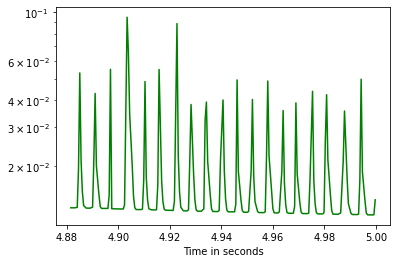

In [47]:
plt.plot(Lin_adap_out.TimeTaken.iloc[-200:-1], Lin_adap_out.GradientNorms.iloc[-200:-1], c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

non-monotone method

Oscilation in Function values (last 200 iterations)

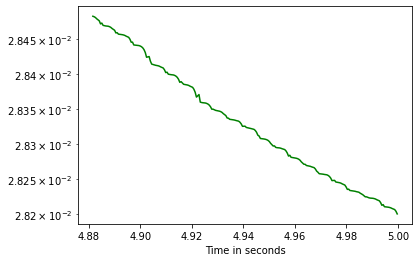

In [48]:
plt.plot(Lin_adap_out.TimeTaken.iloc[-200:-1], Lin_adap_out.FunctionValues.iloc[-200:-1], c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()

In [50]:
print("Van final", Log_vanilla_out.tail())
print("Adap final", Log_adap_out.tail())
print("LS final", Log_line_out.tail())
print("Baz final", Log_baz_out.tail())
print("Nest final", Log_nest_out.tail())

Van final        GradientNorms  TimeTaken  FunctionValues  Accuracy
40901       0.169685   4.999646        0.103069       0.9
40902       0.169682   4.999646        0.103069       0.9
40903       0.169680   4.999646        0.103068       0.9
40904       0.169678   4.999646        0.103067       0.9
40905       0.169675   5.000142        0.103067       0.9
Adap final        GradientNorms  TimeTaken  FunctionValues  Accuracy
25862       0.010151   4.999189        0.006087       0.9
25863       0.007823   4.999684        0.006087       0.9
25864       0.007117   4.999684        0.006087       0.9
25865       0.007040   4.999684        0.006087       0.9
25866       0.007039   5.000223        0.006086       0.9
LS final      GradientNorms  TimeTaken  FunctionValues  Accuracy
306       0.420536   1.953322        0.137341       0.9
307       0.370990   1.957789        0.137280       0.9
308       0.456602   1.966725        0.137101       0.9
309       0.365408   1.971178        0.137042     

In [51]:
Log_nest_out.Accuracy

0        0.009953
1        0.010453
2        0.010453
3        0.010947
4        0.010947
           ...   
39200    4.999750
39201    4.999750
39202    4.999750
39203    4.999750
39204    5.000245
Name: Accuracy, Length: 39205, dtype: float64

Check Lipschitz approx with SVD holds...

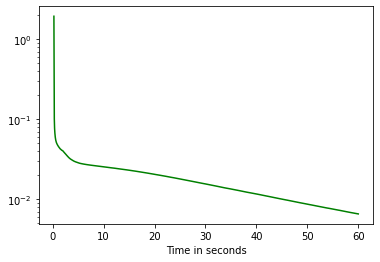

In [36]:
plt.plot(Log_nest_out.TimeTaken, Log_nest_out.FunctionValues, c = 'g')
plt.yscale('log')
plt.xlabel('Time in seconds')
plt.show()